<center><h1 style="color: orange;">Business Case</h1></center>
<center><h1 style="color: green;"> Ninjacart: CV Classification </h1></center>
<center><h2 style="color: black;"> Suman Debnath </h1></center>

<div style="text-align:center;">
  <img src="img1.png" />
</div>


<center><h1 style="color: blue;">Introduction</h1></center>

# Problem Statement

Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems in the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, Ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes, and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

## Dataset Link

[Download the dataset](https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing)

## Context

This dataset contains images of the following food items: noise-Indian market and images of vegetables- onion, potato, and tomato.

## Data Collection

The images in this dataset were scraped from Google.

## Content

This dataset contains a folder `train`, which has a total of 3135 images, split into four folders as follows:

- **Tomato**: 789 images
- **Potato**: 898 images
- **Onion**: 849 images
- **Indian market**: 599 images

This dataset contains another folder `test` which has a total of 351 images, split into four folders as follows:

- **Tomato**: 106 images
- **Potato**: 83 images
- **Onion**: 81 images
- **Indian market**: 81 images

## Inspiration

The objective is to develop a program that can recognize the vegetable item(s) in a photo and identify them for the user.

## Concepts Tested:

- Dataset Preparation & Visualization
- CNN models
- Implementing Callbacks
- Dealing with Overfitting
- Transfer Learning




<center><h1 style="color: green;">Detailed Analysis</h1></center>


## Importing all the `libs`

In [1]:
# Import common libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import tensorflow and its modules
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

## Downloading the `dataset`

In [2]:
#!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

In [3]:
#!unzip ninjacart_data.zip

## Data Exploration 

In [4]:
dataset_path = '../../dataset/ninjacart_data'

train_path = f"{dataset_path}/train/"
test_path = f"{dataset_path}/test/"

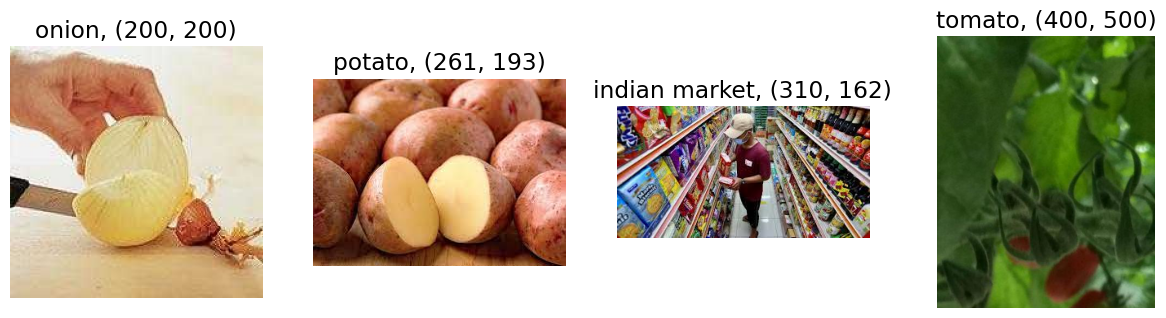

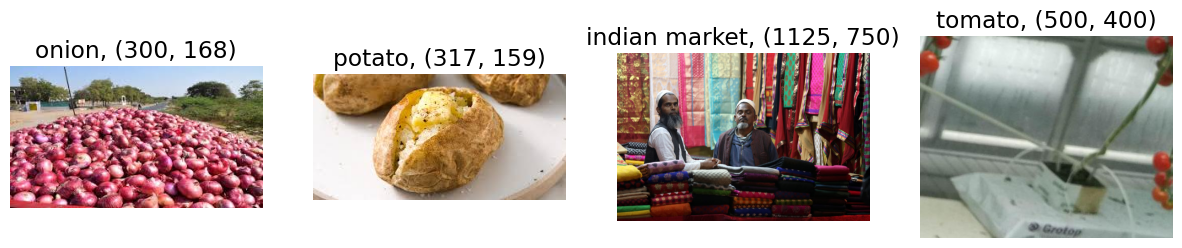

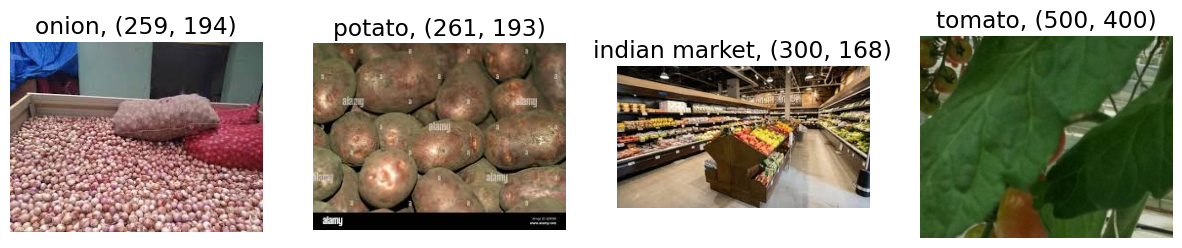

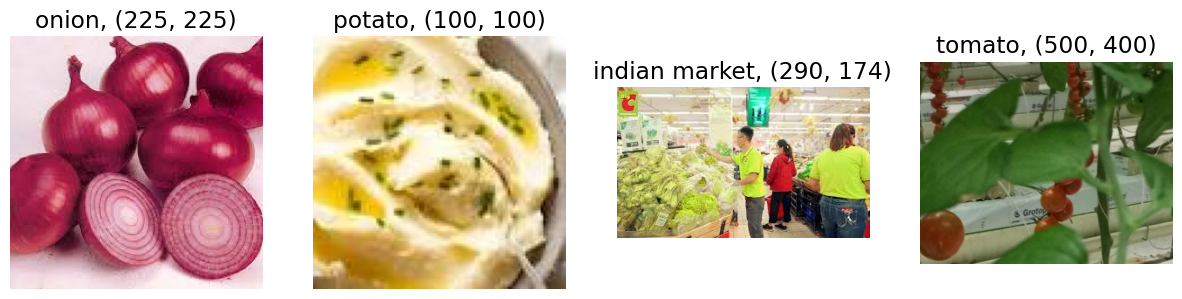

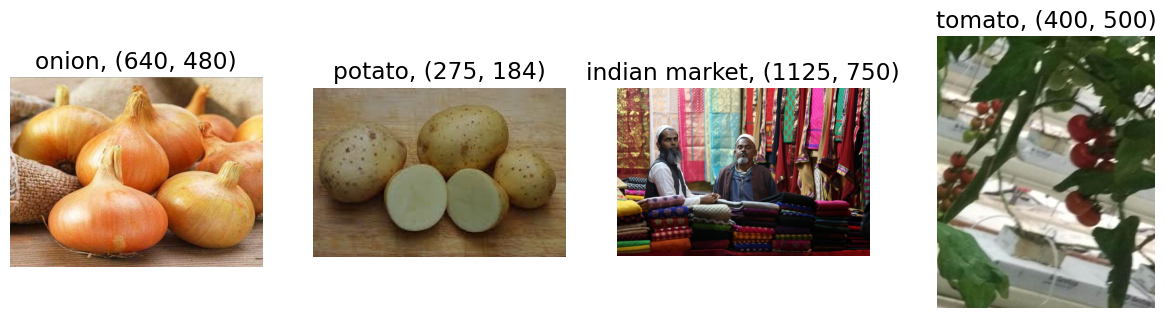

In [5]:
class_dirs = os.listdir(f"{train_path}") 
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)

for _ in range(5):
    # iterate over all class_dirs
    for cls in class_dirs:
        # get list of all paths inside the subdirectory
        file_paths = glob.glob(f'{train_path}/{cls}/*')
        # count number of files in each class and add it to count_dict
        count_dict[cls] = len(file_paths)
        # select random item from list of image paths
        image_path = random.choice(file_paths)
        # load image using keras utility function and save it in image_dict
        image_dict[cls] = tf.keras.utils.load_img(image_path)
    
    ## Viz Random Sample from each class    
    plt.figure(figsize=(15, 12))
    # iterate over dictionary items (class label, image array)
    for i, (cls,img) in enumerate(image_dict.items()):    
        # create a subplot axis
        ax = plt.subplot(3, 4, i + 1)
        # plot each image
        plt.imshow(img)
        # set "class name" along with "image size" as title 
        plt.title(f'{cls}, {img.size}')
        plt.axis("off")
        
    plt.show()

- Notice that every Image has different dimension!

In [6]:
for product, n in count_dict.items():
    print(f"{product}: {n}")

onion: 849
potato: 898
indian market: 599
tomato: 789


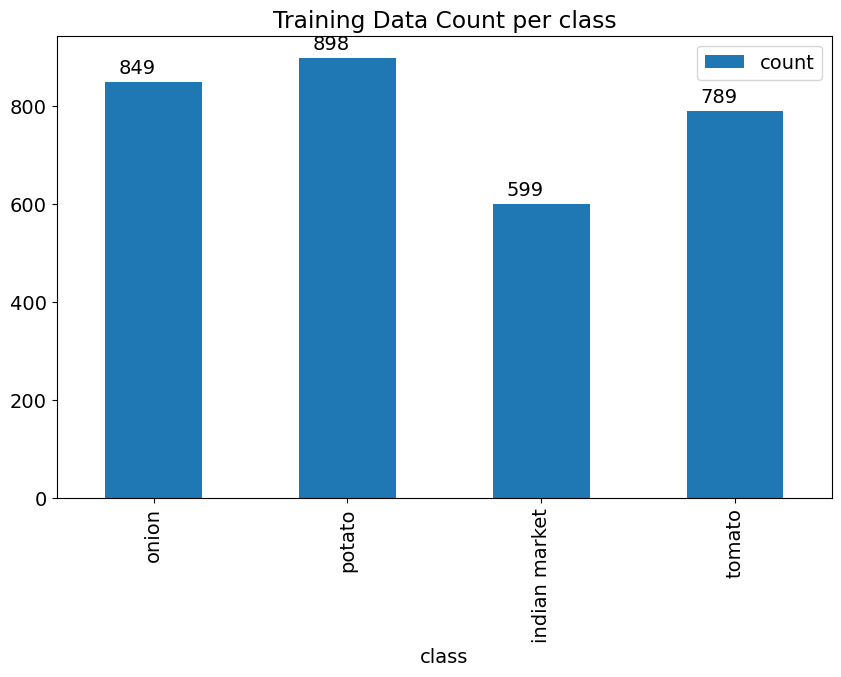

In [7]:
# Creating the DataFrame
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})

# Plotting with size adjustment
ax = df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class", figsize=(10, 6))

# Adding labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 3., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

- Note that the train/test split already provided, we needn't create it explicitly!
- Also, we can observe that the data almost balanced (except the fact that there is little less data available for `india market` class)

## Load the `dataset`

In [9]:
# Specifying the image size to resize all images
image_size = (256, 256)
image_shape = (256, 256, 3)

train_data = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                         label_mode = 'categorical',
                                                         shuffle = True, 
                                                         seed= 2024,
                                                         validation_split = 0.2,
                                                         subset = 'training',
                                                         image_size = image_size,
                                                         batch_size = 32)

val_data = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       shuffle = True, 
                                                       seed= 2024,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       image_size = image_size,
                                                       batch_size = 32)

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_path,
                                                        label_mode = 'categorical',
                                                        shuffle = False, 
                                                        seed=2024,
                                                        image_size = image_size,
                                                        batch_size = 32)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Found 351 files belonging to 4 classes.


In [10]:
# Get the first batch of images and labels from the train dataset
for images, labels in train_data.take(1):
    first_image = images[0]
    first_label = labels[0]
    print("Shape of the first batch of images in train_data:", images.shape)
    print("Shape of the first batch of labels in train_data:", labels.shape)

Shape of the first batch of images in train_data: (32, 256, 256, 3)
Shape of the first batch of labels in train_data: (32, 4)


2024-06-19 10:30:18.333755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Building the model using `Transfer Learning`

### Image Preprocessing (`Rescaling`)

In [11]:
from tensorflow.keras import layers 

# Define data preprocessing pipeline
data_preprocess = tf.keras.Sequential(
                                        name="data_preprocess",
                                        layers=[layers.Rescaling(1.0/255)]
                                    )

# # Perform Data Processing on the train, val, test dataset
# train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
# val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
# test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))




### VGG-19 (`without` Data Augmentation)

In [12]:
image_shape

(256, 256, 3)

In [40]:
pretrained_model = tf.keras.applications.VGG19(
                                               weights='imagenet', 
                                               include_top=False, 
                                               input_shape=image_shape)

pretrained_model.trainable=False
     
vgg19_model = tf.keras.Sequential([     
                                        layers.Input(shape=image_shape),
                                        data_preprocess,
                                        pretrained_model,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dropout(rate = 0.1),
                                        tf.keras.layers.Dense(4, activation='softmax')
                                    ])

In [41]:
vgg19_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_preprocess (Sequential)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [42]:
log_dir = "../../logs/VGG19"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG19-1.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                     patience = 5, 
                                                     restore_best_weights=True
                                                    )

In [43]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.002)
vgg19_model.compile(
                        optimizer=opt,
                        loss = 'categorical_crossentropy',
                        metrics=['accuracy']
                    )

# print(vgg19_model.optimizer.get_config())

model_fit = vgg19_model.fit(
                            train_data,  
                            epochs=25,
                            validation_data=val_data,
                            callbacks=[tensorboard_cb, 
                                       checkpoint_cb, 
                                       early_stopping_cb]
                          )

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 472ms/step - accuracy: 0.4785 - loss: 1.2239 - val_accuracy: 0.7927 - val_loss: 0.7622
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - accuracy: 0.7732 - loss: 0.7304 - val_accuracy: 0.8533 - val_loss: 0.5700
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.8146 - loss: 0.5792 - val_accuracy: 0.8772 - val_loss: 0.4808
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step - accuracy: 0.8468 - loss: 0.5022 - val_accuracy: 0.8836 - val_loss: 0.4283
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - accuracy: 0.8466 - loss: 0.4604 - val_accuracy: 0.8884 - val_loss: 0.4035
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - accuracy: 0.8613 - loss: 0.4095 - val_accuracy: 0.8900 - val_loss: 0.3709
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - accuracy: 0.8754 - loss: 0.3804 - val_accuracy: 0.8772 - val_loss: 0.3608
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - accuracy: 0.8684 - loss: 0.3782 - val_accu

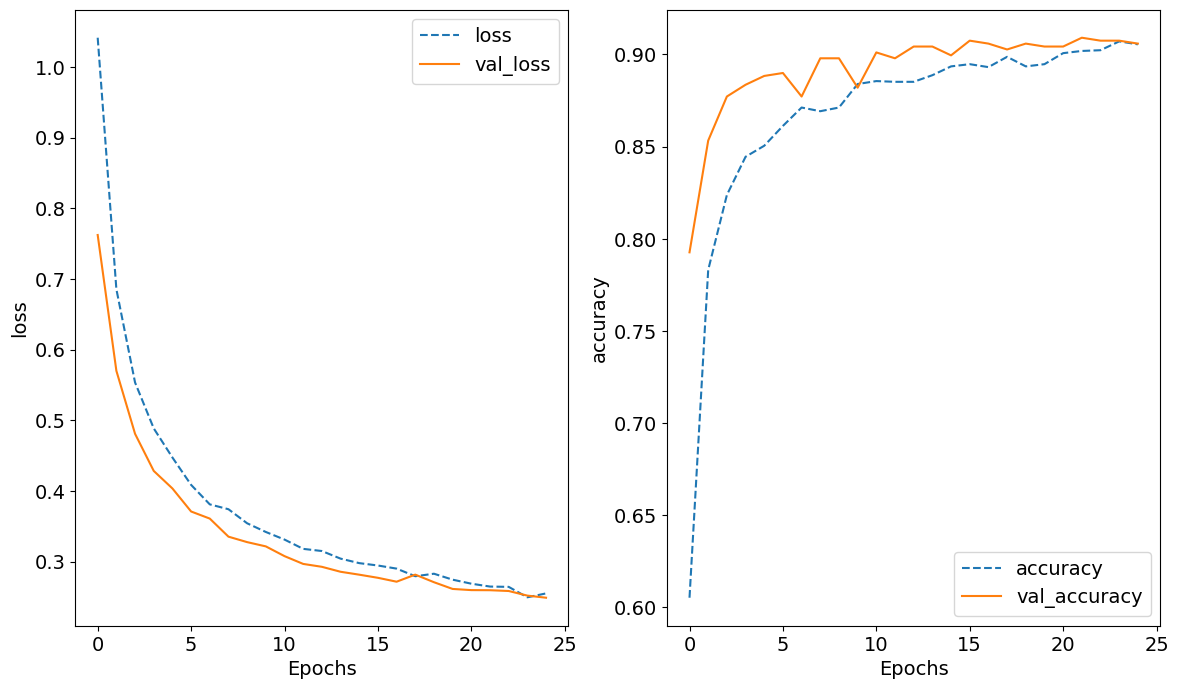

In [44]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(7*len(metrics), 8))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])


training_plot(['loss', 'accuracy'], model_fit)


In [45]:
# Evaluate the model
loss, acc = vgg19_model.evaluate(test_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

11/11 - 4s - 369ms/step - accuracy: 0.8433 - loss: 0.4245
Restored model, accuracy: 84.33%


11/11 - 4s - 369ms/step - accuracy: 0.8433 - loss: 0.4245
Test accuracy: 0.8433048725128174
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step


2024-06-19 10:57:54.935328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


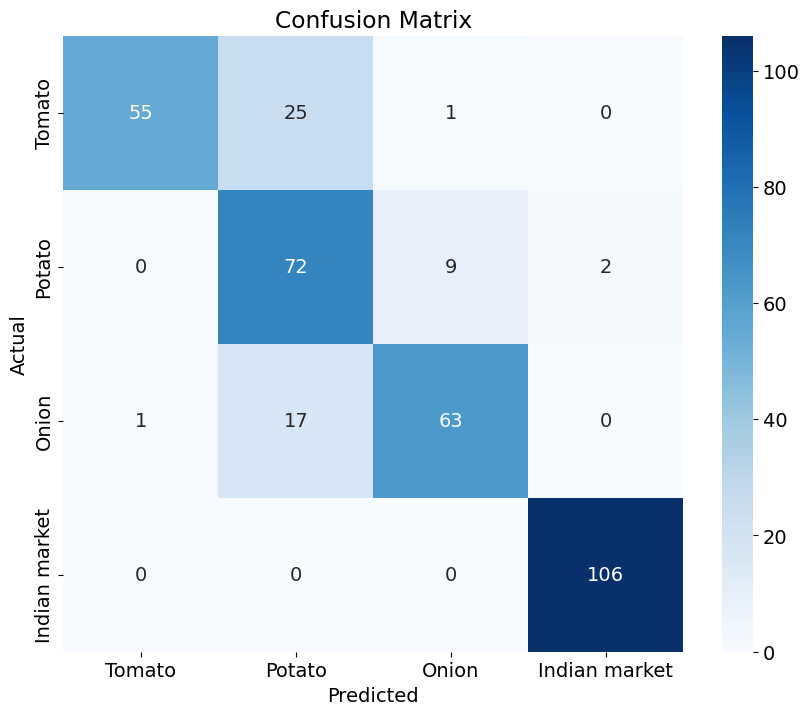

               precision    recall  f1-score   support

       Tomato       0.98      0.68      0.80        81
       Potato       0.63      0.87      0.73        83
        Onion       0.86      0.78      0.82        81
Indian market       0.98      1.00      0.99       106

     accuracy                           0.84       351
    macro avg       0.86      0.83      0.84       351
 weighted avg       0.87      0.84      0.85       351



In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = vgg19_model.evaluate(test_data, verbose=2)
print(f"Test accuracy: {test_acc}")

# Get predictions from the model
predictions = vgg19_model.predict(test_data)
pred_labels = np.argmax(predictions, axis=1)

# Create a mapping for class names
classes = ['Tomato', 'Potato', 'Onion', 'Indian market']
label_map = {label: idx for idx, label in enumerate(classes)}
reverse_label_map = {v: k for k, v in label_map.items()}

# Extract actual labels from the test dataset
actual_labels = []
for _, label in test_data.unbatch():
    actual_labels.append(label.numpy())

actual_labels = np.array(actual_labels)
actual_labels = np.argmax(actual_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(actual_labels, pred_labels, target_names=classes))


### VGG-19 (`with` Data Augmentation)

In [47]:
from tensorflow.keras import layers 

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential(
                                            name="data_augmentation",
                                            layers=[
                                                layers.RandomFlip("horizontal_and_vertical"),
                                                layers.RandomRotation(0.2),
                                                layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
                                            ]
                                        )

# Define data preprocessing pipeline
data_preprocess = tf.keras.Sequential(
                                        name="data_preprocess",
                                        layers=[layers.Rescaling(1.0/255)]
                                    )

In [48]:
# Load pre-trained VGG19 model
pretrained_model = tf.keras.applications.VGG19(
                                                    weights='imagenet', 
                                                    include_top=False, 
                                                    input_shape=image_shape
                                                )
pretrained_model.trainable = False

# Create the Sequential model
vgg19_model = tf.keras.Sequential([
                                    layers.Input(shape=image_shape),
                                    data_augmentation,
                                    data_preprocess,
                                    pretrained_model,
                                    layers.GlobalAveragePooling2D(),
                                    layers.Dropout(rate=0.1),
                                    layers.Dense(4, activation='softmax')
                                ])

In [49]:
vgg19_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_preprocess (Sequential)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [50]:
log_dir = "../../logs/VGG19"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG19.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                     patience = 5, 
                                                     restore_best_weights=True
                                                    )

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.002)
vgg19_model.compile(
                        optimizer=opt,
                        loss = 'categorical_crossentropy',
                        metrics=['accuracy']
                    )

# print(vgg19_model.optimizer.get_config())

model_fit = vgg19_model.fit(
                            train_data,  
                            epochs=30,
                            validation_data=val_data,
                            callbacks=[tensorboard_cb, 
                                       checkpoint_cb, 
                                       early_stopping_cb]
                          )

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - accuracy: 0.4979 - loss: 1.1859 - val_accuracy: 0.7735 - val_loss: 0.7932
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.7434 - loss: 0.7884 - val_accuracy: 0.8102 - val_loss: 0.6220
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.7898 - loss: 0.6569 - val_accuracy: 0.8389 - val_loss: 0.5284
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.7984 - loss: 0.5930 - val_accuracy: 0.8708 - val_loss: 0.4769
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.8134 - loss: 0.5356 - val_accuracy: 0.8676 - val_loss: 0.4450
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8169 - loss: 0.5064 - val_accuracy: 0.8740 - val_loss: 0.4193
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.8234 - loss: 0.4821 - val_accuracy: 0.8836 - val_loss: 0.3912
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 498ms/step - accuracy: 0.8136 - loss: 0.4815 - val_accu

In [ ]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(7*len(metrics), 8))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])


training_plot(['loss', 'accuracy'], model_fit)


In [ ]:
# Evaluate the model
loss, acc = vgg19_model.evaluate(test_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = vgg19_model.evaluate(test_data, verbose=2)
print(f"Test accuracy: {test_acc}")

# Get predictions from the model
predictions = vgg19_model.predict(test_data)
pred_labels = np.argmax(predictions, axis=1)

# Create a mapping for class names
classes = ['Tomato', 'Potato', 'Onion', 'Indian market']
label_map = {label: idx for idx, label in enumerate(classes)}
reverse_label_map = {v: k for k, v in label_map.items()}

# Extract actual labels from the test dataset
actual_labels = []
for _, label in test_data.unbatch():
    actual_labels.append(label.numpy())

actual_labels = np.array(actual_labels)
actual_labels = np.argmax(actual_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(actual_labels, pred_labels, target_names=classes))


### ResNet-50 (`with` Data Augmentation)

In [ ]:
# Load pre-trained VGG19 model
pretrained_model = tf.keras.applications.ResNet50(
                                                    weights='imagenet', 
                                                    include_top=False, 
                                                    input_shape=image_shape
                                                )
pretrained_model.trainable = False

# Create the Sequential model
resnet50_model = tf.keras.Sequential([
                                    layers.Input(shape=image_shape),
                                    data_augmentation,
                                    data_preprocess,
                                    pretrained_model,
                                    layers.GlobalAveragePooling2D(),
                                    layers.Dropout(rate=0.1),
                                    layers.Dense(4, activation='softmax')
                                ])

resnet50_model.summary()

In [ ]:
log_dir = "../../logs/resnet50"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("resnet50.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                     patience = 5, 
                                                     restore_best_weights=True
                                                    )

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.002)
resnet50_model.compile(
                        optimizer=opt,
                        loss = 'categorical_crossentropy',
                        metrics=['accuracy']
                    )

# print(vgg19_model.optimizer.get_config())

model_fit = resnet50_model.fit(
                                train_data,  
                                epochs=30,
                                validation_data=val_data,
                                callbacks=[tensorboard_cb, 
                                           checkpoint_cb, 
                                           early_stopping_cb]
                              )

In [ ]:
training_plot(['loss', 'accuracy'], model_fit)

In [ ]:
# Evaluate the model
loss, acc = resnet50_model.evaluate(test_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = resnet50_model.evaluate(test_data, verbose=2)
print(f"Test accuracy: {test_acc}")

# Get predictions from the model
predictions = resnet50_model.predict(test_data)
pred_labels = np.argmax(predictions, axis=1)

# Create a mapping for class names
classes = ['Tomato', 'Potato', 'Onion', 'Indian market']
label_map = {label: idx for idx, label in enumerate(classes)}
reverse_label_map = {v: k for k, v in label_map.items()}

# Extract actual labels from the test dataset
actual_labels = []
for _, label in test_data.unbatch():
    actual_labels.append(label.numpy())

actual_labels = np.array(actual_labels)
actual_labels = np.argmax(actual_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(actual_labels, pred_labels, target_names=classes))